# Earth-Moon RTBP

This example examine the dynamics of a probe in an Earth-Moon three body system.

In this tutorial, we will construct both a family of Halo and DRO. We will then plot stable and unstable manifold for a selected Halo orbit. Then, we will investigate the possibility of departing from an Earth LEO to go to the Halo, using a set of impulses and the Halo orbit stable manifold.

Before starting, let's import the usual modules.

In [1]:
import r3bpy
from r3bpy.main import Problem, Manifold
import r3bpy.core as constants
from r3bpy.orbits import print_info

In [2]:
import numpy as np

In [3]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 10]

## RTBP definition

We now defined the restricted three body problem parameters. Consider the case of the asteroid binary system 1999 KW4.

In [4]:
r12 = constants.DISTANCE_EARTH_MOON
m1 = constants.MU_EARTH
m2 = constants.MU_MOON

In [5]:
problem = Problem(m1, m2, r12)
mu_ratio = problem.get_mu_ratio()
DU = problem.get_distance_normalisation()
TU = problem.get_time_normalisation()
print("mu_ratio=",mu_ratio)

mu_ratio= 0.012150586632602434


Values "DU" and "TU" represent respectively the distance and time normalisation constants.

Let's have a model representation of the system. 

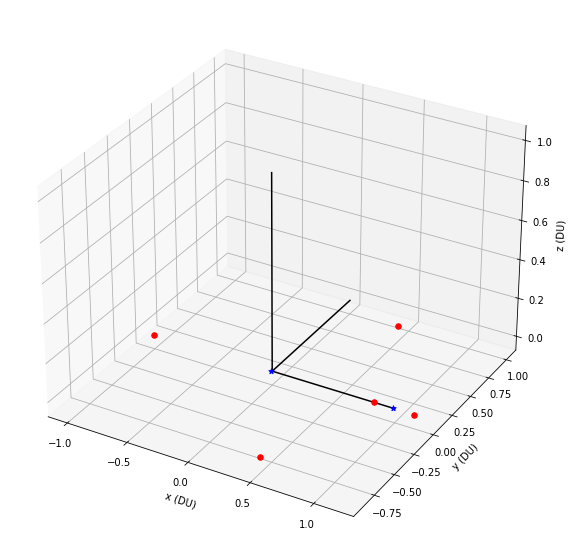

In [6]:
from r3bpy.visu import plot_trajectory, plot_system

ax, fig = r3bpy.visu.init_figure(False)
plot_system(problem, is2d=False, withAxes=True, ax=ax)
plt.show()

## Libration orbits

### Family of Halo orbits

We would now compute and plot the Libration points of this system, as well as a Halo orbit near the Moon.

In [7]:
from r3bpy.orbits import HaloOrbit

Ax = 5000e3 / DU  # amplitude of the lissajous orbit
libration_point = problem.get_libration_point_info(r3bpy.main.L1)
halo_l1 = HaloOrbit(libration_point)
halo_l1_orbit = halo_l1.find_orbit(Ax, False, 200, 1e-8)

In [8]:
orbit_period = halo_l1_orbit.period
print_info(halo_l1_orbit)
print("Orbit amplitudes: ", halo_l1_orbit.Ax, halo_l1_orbit.Ay, halo_l1_orbit.Az)

Orbit type           : halo
      period         : 2.744300
      Libration Point: L0
      Primaries      :  
Orbit amplitudes:  0.015899806930014138 0.0 0.01296371197743277


We can as well generate part of the family of Halo orbits around L1. Again, no need much code, most of it is for plotting!

In [9]:
AxInit = 10000.0e3 / DU
AxFinal = 75000.0e3 / DU
AxStep = 2000.0e3 / DU
ax_grid = np.arange(AxInit, AxFinal, AxStep)

libration_point = problem.get_libration_point_info(r3bpy.main.L1)
halo_family = HaloOrbit(libration_point)
halo_stability_index = []
current_halo_orbit = None
halo_family_sols = []

for x in ax_grid:
    if current_halo_orbit is None:
        current_halo_orbit = halo_family.find_orbit(x, False, 50, 1e-6, 1.0)
    else:  # use previous solution to compute new Halo
        current_halo_orbit = halo_family.find_orbit(x, current_halo_orbit, False, 20, 1e-6, 1.)        

    if current_halo_orbit.is_valid:
        halo_family_sols.append(current_halo_orbit)        
        halo_stability_index.append([x, current_halo_orbit.get_periapsis(r3bpy.main.P2), current_halo_orbit.get_stability_index(), current_halo_orbit.mnu1, current_halo_orbit.mnu2])
    else:
        current_halo_orbit = None

halo_stability_index = np.array(halo_stability_index)        

<Axes3DSubplot:xlabel='x (DU)', ylabel='y (DU)'>

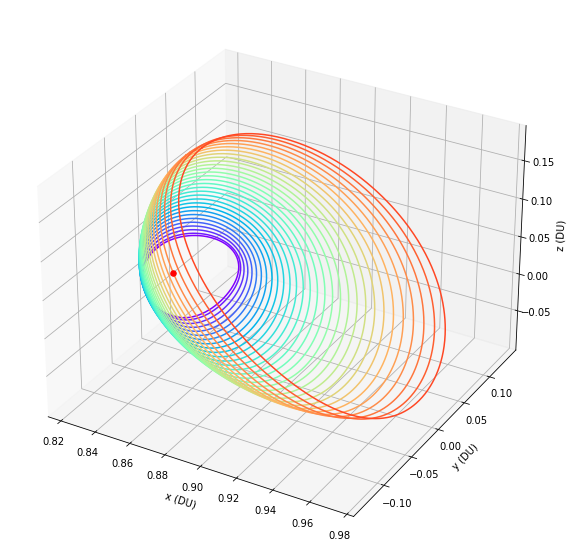

In [10]:
def plot_halo(halo_orbit, color, ax):
    orbit_period = halo_orbit.period
    _, xyz = halo_orbit.propagate([0, orbit_period])
    return plot_trajectory(xyz, color=color, ax=ax)

colors = plt.cm.rainbow(np.linspace(0, 1, ax_grid.size))
icolor = 0

ax, fig = r3bpy.visu.init_figure(False)
for current_halo_orbit in halo_family_sols:    
    ax = plot_halo(current_halo_orbit, colors[icolor], ax)
    icolor = icolor + 1
#plot_halo(halo_family_sols[15], 'black', ax)    
plot_system(problem, is2d=False, ax=ax, primaryList=[], colinearPointsList=[1], withTriangularPoints=False)

And, in the Earth centered inertial frame,

In [11]:
from r3bpy.main import Frame, Propagator

TU = problem.get_time_normalisation()

# propagate the one Halo orbit of the family. We will use again later.
halo_l1_orbit = halo_family_sols[5]
t, xyz_halo = halo_l1_orbit.propagate([0, orbit_period])

p = [x[0:3] for x in xyz_halo]
t = [x for x in t]

f = Frame(problem)
xyz_halo_in = f.to_frame(t, list(p))

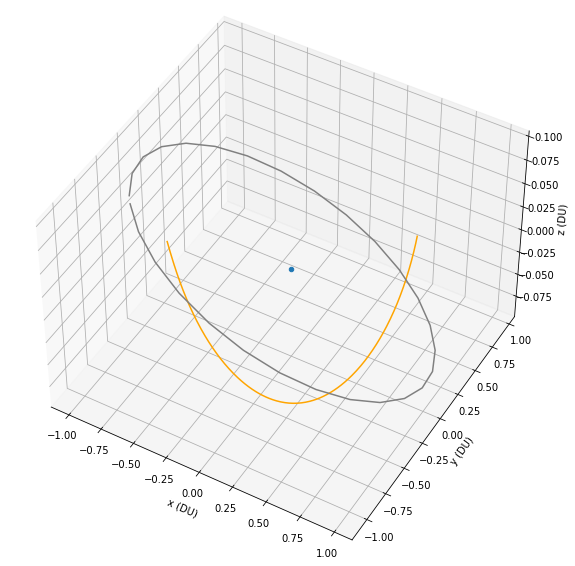

In [12]:
from r3bpy.main.bodies import Moon
from r3bpy.visu import plot_orbit

DU = problem.get_distance_normalisation()

ax, fig = r3bpy.visu.init_figure(False)
plot_trajectory(xyz_halo_in, color='orange', ax=ax)
Moon.plot_orbit( [0., problem.get_synodic_period() / 86400.], ax, color='grey', a_m=1/DU)
ax.scatter(0,0,0) # Earth
ax.view_init(elev=45.)  

We can also plot the closest distance to the Moon (periselene)

In [13]:
halo_ax = []
halo_period = []
halo_rp = []
for orbit in halo_family_sols:
    halo_ax.append(orbit.Az)
    halo_period.append(orbit.period)
    halo_rp.append(orbit.get_periapsis(r3bpy.main.P2))
halo_period = np.array(halo_period)
halo_rp = np.array(halo_rp)
halo_ax = np.array(halo_ax)

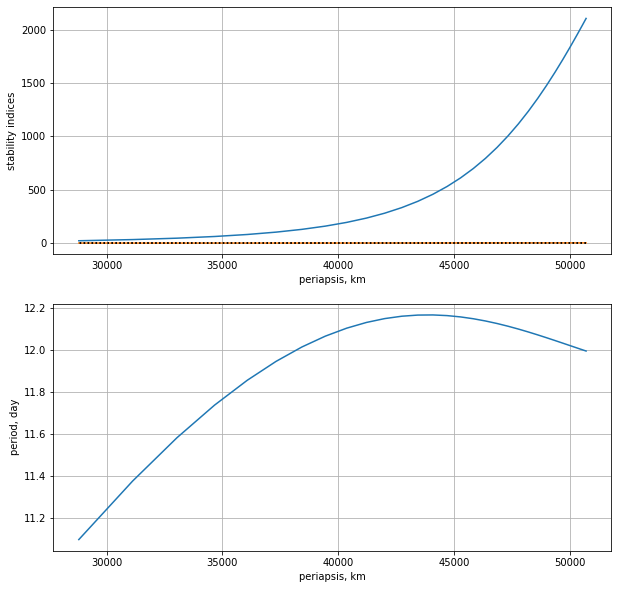

In [14]:
p = halo_rp * DU / 1000.

fig = plt.figure()
ax = fig.add_subplot()

ax = plt.subplot(2,1,1)
ax.plot(p, halo_stability_index[:,3])
ax.plot(p, halo_stability_index[:,4])
ax.plot(p, 1 * np.ones(len(p)), "k:")
ax.plot(p,-1 * np.ones(len(p)), "k:")
ax.grid()
ax.set_ylabel('stability indices')
ax.set_xlabel('periapsis, km')

ax = plt.subplot(2,1,2)
ax.plot(p, halo_period * TU / 86400)
ax.grid()
ax.set_ylabel('period, day')
ax.set_xlabel('periapsis, km')

plt.show()

The stability index of the L1 Halo orbit varies significantly with the perilune radius. On the far left, exists the sub-family of Near Rectilinear Halo orbit, while on the far right Halo orbit are nearly planar.

### Family of DRO

Distant Retrograde Orbit (DRO) are interesting orbits in the RTBP because of their stability (Lyapunov criterion). Those orbits not only revolve around the primary but also passe near Libration points L1 and L2. In addition, the orbital period could be far much than the sidereal period of the primaries. Both points for sure can have interesting practical and operational advantages.

I do not know why there were no mission using this type of orbit.

In [15]:
from r3bpy.main import PrimaryPointId
from r3bpy.orbits import DistantRetrogradeOrbit

Defining a DRO is as simple as defining a Halo.

In [16]:
dro = DistantRetrogradeOrbit(mu_ratio, PrimaryPointId.P2)

We will construct and plot a family of DRO. 

For convenience we first declare a plotting function that propagate the DRO for one period and plot it.

In [17]:
def plot_dro(dro_orbit, color, ax):
    orbit_period = dro_orbit.period
    _, xyz = dro_orbit.propagate([0, orbit_period])
    return plot_trajectory(xyz, color=color, ax=ax)

Now we can construct the family.

The construction is done iteratively, using previous DRO orbit if defined, and increasing the orbit parameter $x_{pos}$. We make $x_{pos}$ vary beteen 1.1 and 1.3 DU.

In [18]:
x_init = 400000e3 / r12
x_final = 500000e3 / r12
x_step = 5000e3 / r12

xlist = np.arange(x_init, x_final, x_step)

dro_stability_index = []
dro_orbit_family = []

dro_orbit = None
icolor = 0
for xpos in xlist:
    if dro_orbit is None:
        dro_orbit = dro.find_orbit(xpos, False, 50)
    else:  # use previous solution to compute new DRO
        dro_orbit = dro.find_orbit(xpos, False, 50)

    dro_orbit_family.append(dro_orbit)
    dro_stability_index.append([xpos, dro_orbit.get_periapsis(r3bpy.main.P2), dro_orbit.get_stability_index(), dro_orbit.period])

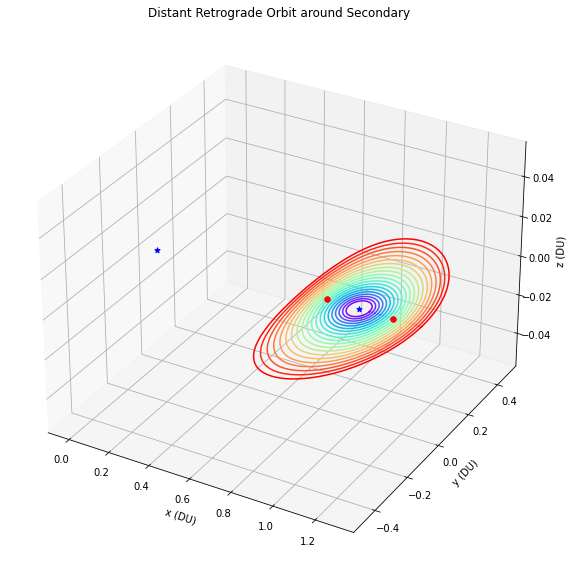

In [19]:
colors = plt.cm.rainbow(np.linspace(0, 1, xlist.size))

ax = plot_system(problem, is2d=False, withPrimaries=True, withTriangularPoints=False, colinearPointsList=[1,2])
dro_orbit = None
icolor = 0
for dro_orbit in dro_orbit_family:
    ax = plot_dro(dro_orbit, colors[icolor], ax)
    icolor = icolor + 1
plt.title("Distant Retrograde Orbit around Secondary")
plt.show()

The stability index is given by the Eigen value of the Monodromy matrix. 

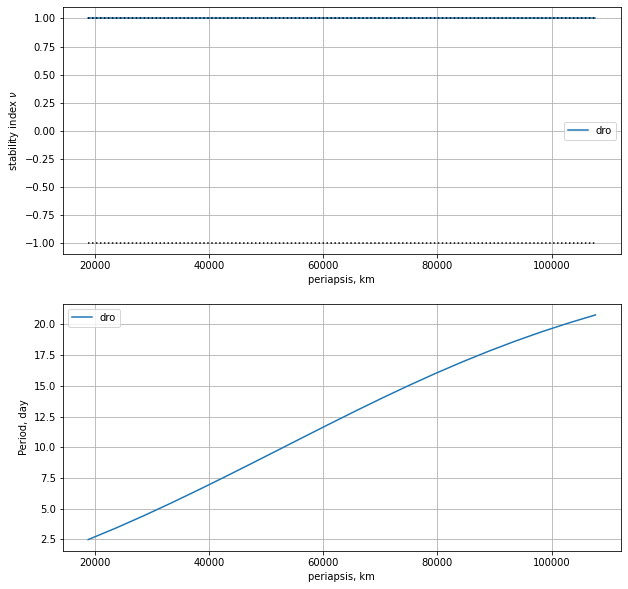

In [20]:
dro_stability_index = np.array(dro_stability_index)

p = dro_stability_index[:,1] * DU / 1000.;

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.plot(p, dro_stability_index[:,2], label='dro')
ax.plot(p, 1 * np.ones(len(p)), "k:")
ax.plot(p, -1 * np.ones(len(p)), "k:")
ax.legend()
ax.grid()
ax.set_xlabel('periapsis, km')
ax.set_ylabel('stability index $\\nu$')

ax = fig.add_subplot(2,1,2)
ax.plot(p, dro_stability_index[:,3] * TU / 86400, label='dro')
ax.legend()
ax.grid()
ax.set_xlabel('periapsis, km')
ax.set_ylabel('Period, day')

plt.show()

### Orbit comparison

The fact that the stability index remains close to one, for a DRO, means that from a linear analysis, the DRO is always marginally stable. 
For the Halo, we observed that the index can quickly takes large values, meaning that small perturbation will tend as small mass on the Halo to depart the orbit.

## Transfer to Halo orbit
### Manifolds from Halos

We now construct manifolts departing from this orbit.

In [21]:
manifolds = Manifold(halo_l1_orbit)
stable_vector_space = manifolds.get_stableManifold_basis()
unstable_vector_space = manifolds.get_unstableManifold_basis()
center_vector_space = manifolds.get_centerManifold_basis()

We can now plot again the previous binary system with the stable and unstable manifolds (when they exist).

In [22]:
stable_vector_space, unstable_vector_space, center_vector_space

([array([-0.33427036-0.02412992j, -0.10180353-0.00734888j,
          0.02291747+0.00165434j,  0.84737601+0.0611694j ,
          0.3613885 +0.02608749j, -0.15343557-0.01107603j]),
  array([ 0.05310628-0.09500127j, -0.34502154-0.19286913j,
          0.17283672-0.30918577j, -0.34401649-0.1923073j ,
         -0.2877553 +0.51476242j, -0.39360288-0.22002639j]),
  array([ 0.09810111-0.04713483j,  0.17118225+0.35627939j,
          0.31927432-0.15340235j,  0.17068359+0.35524155j,
         -0.53155881+0.25539908j,  0.19528585+0.40644591j])],
 [array([ 0.33514016-3.02028285e-05j, -0.10206843+9.19840591e-06j,
         -0.02297711+2.07069656e-06j,  0.84958095-7.65642280e-05j,
         -0.36232886+3.26530741e-05j, -0.15383483+1.38635932e-05j])],
 [array([ 1.14839848e-06+2.46592677e-06j,  4.92245895e-01-2.29242177e-01j,
          2.92163750e-05+6.27355780e-05j,  4.08263201e-01-1.90130880e-01j,
          3.21784917e-05+6.90960554e-05j, -6.42485054e-01+2.99209550e-01j]),
  array([ 2.59708396e-06+8.0917

We can now plot again the previous binary system with the stable and unstable manifolds (when they exist).

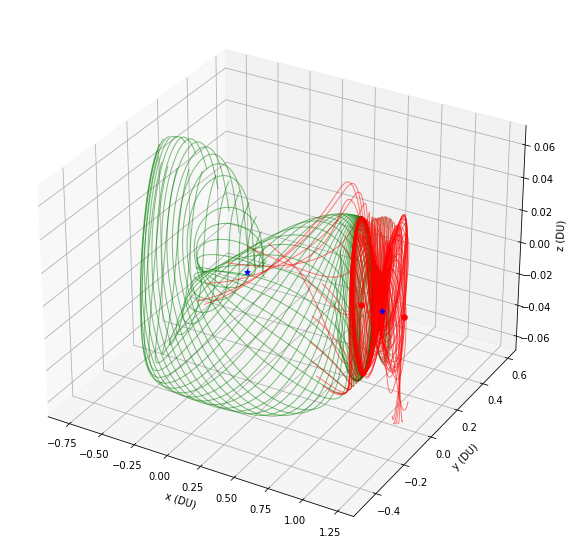

In [23]:
from r3bpy.visu import plot_system, plot_manifold, plot_trajectory

ax = plot_system(problem, is2d=False, withTriangularPoints=False, colinearPointsList=[1,2])
plot_trajectory(xyz_halo, ax=ax, color='orange')
if stable_vector_space:
    plot_manifold(mu_ratio, xyz_halo, orbit_period, stable_vector_space[0], max_duration=-4, displace=0.01, color='g', ax=ax)
    plot_manifold(mu_ratio, xyz_halo, orbit_period, stable_vector_space[0], max_duration=4, displace=-0.01, color='g', ax=ax)
if unstable_vector_space:
    plot_manifold(mu_ratio, xyz_halo, orbit_period, unstable_vector_space[0], max_duration=4, displace=0.01, color='r', ax=ax)
    plot_manifold(mu_ratio, xyz_halo, orbit_period, unstable_vector_space[0], max_duration=-4, displace=-0.01, color='r', ax=ax)
plt.show()

### Earth Transfer to Halo orbit

We will construct a transfer from Earth to a Lunar libration orbit about the Earth-Moon L1 point.

Direct transfers are designed using the stable manifold of the target libration point orbit. Here, we will target a Halo orbit, but the approach is similar for other orbits such as NRHO, Vertical/Horizonal Lyapunov.
One difficulty, hinted in the previous section, is that the stable manifold of L1 (or L2) Halo orbits do not intersect Earth orbit in short time. We will thus need to perform several maneuvers to rendezvous from a LEO (Low Earth Orbit) to a Lunar Halo orbit's stable manifold.

For simplicity, only two maneuvers will be implemented. This is by no mean optimal, but it should provide some good insight of all this works.
The first maneuver will be called the trans-lunar injection maneuver, followed by a ballistic phase (the bridge). The second maneuver will be performed when the bridge and the manifold intersect, at the manifold injection point. This will eventually be followed by the manifold segment. The manifold segment will yield to the selected Lunar L1 Halo orbit.

The LEO orbit parameters are:
 - altitude: 400 km 
 - anomaly: free
 
Earth-Moon L1 Halo orbit parameters:
 - direction: interior or exterior
 - tau: free
 - amplitude Ax: 300000 km TBD

#### The manifold

In [24]:
print_info(halo_l1_orbit)
print("Orbit amplitudes: ", halo_l1_orbit.Ax, halo_l1_orbit.Ay, halo_l1_orbit.Az)

Orbit type           : halo
      period         : 2.759577
      Libration Point: L0
      Primaries      :  
Orbit amplitudes:  0.017177389239824453 0.0 0.007826674788619965


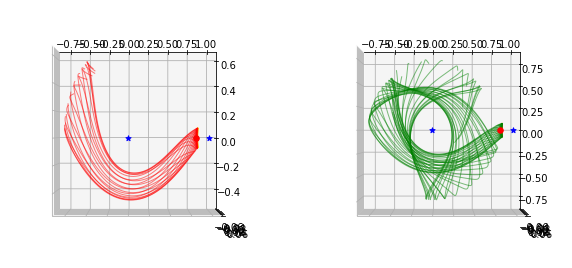

In [25]:
from r3bpy.visu import plot_system, plot_manifold, plot_trajectory

fig = plt.figure()
ax= fig.add_subplot(1, 2, 1, projection='3d')
ax=plot_system(problem, is2d=False, withTriangularPoints=False, colinearPointsList=[1], ax=ax)
plot_trajectory(xyz_halo, color='orange',ax=ax)
plot_manifold(mu_ratio, xyz_halo, orbit_period, stable_vector_space[0], npts=20, max_duration=-4, displace=0.01, color='r', ax=ax)
ax.view_init(elev=90., azim=270)   

ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_system(problem, is2d=False, withTriangularPoints=False, colinearPointsList=[1], ax=ax)
plot_trajectory(xyz_halo, color='orange',ax=ax)
plot_manifold(mu_ratio, xyz_halo, orbit_period, stable_vector_space[0], npts=20, max_duration=-10, displace=0.001, color='g', ax=ax)
ax.view_init(elev=90., azim=270)   



Both stable manifolds, in red the external one, in green the "internal" one.

Note: because a Halo orbit is used to construct the manifold, it is important that the solution is as accurate as possible. You can adjust the tolerance in find_orbit if necessary.

#### The bridge

Let's propagate a transfer from Earth.

In [26]:
import numpy as np
from r3bpy.main import Propagator
mu = constants.MU_EARTH
r = constants.EGM96_EARTH_EQUATORIAL_RADIUS + 400.e3
period = 2 * np.pi * np.sqrt(r**3 / mu)
print("Period: {} s".format(period))

# start point with normalisation
a_m = r12
a_ms =  np.sqrt((m1 + m2) / r12)
a_s = a_m / a_ms

w0 = np.sqrt((m1 + m2) / r12**3) * a_s
print("w0=", w0, "  T=", (2 * np.pi / w0) * (a_s / 86400.), " days")
print("Dist_Earth=", -mu_ratio * a_m, " m")
print(mu_ratio)
init_point_eci = [r / a_m, 0., 0., 0., np.sqrt(mu / r) / a_ms, 0.]
print("x0_eci=", init_point_eci)
init_point = [r / r12 - mu_ratio, 0., 0., 0., np.sqrt(mu / r) / a_ms - (r / r12 - mu_ratio) * w0, 0]
print("x0_rtbp=", init_point)

propagator = Propagator(mu_ratio)
t, p = propagator.propagate(init_point,[0,  period/a_s])
p = np.array(p)

Period: 5553.62347296362 s
w0= 0.9999999999999999   T= 27.422280082989452  days
Dist_Earth= -4686384.059501698  m
0.012150586632602434
x0_eci= [0.017573961347396368, 0.0, 0.0, 0.0, 7.497397545780187, 0.0]
x0_rtbp= [0.005423374714793934, 0.0, 0.0, 0.0, 7.491974171065393, 0]


<Figure size 720x720 with 0 Axes>

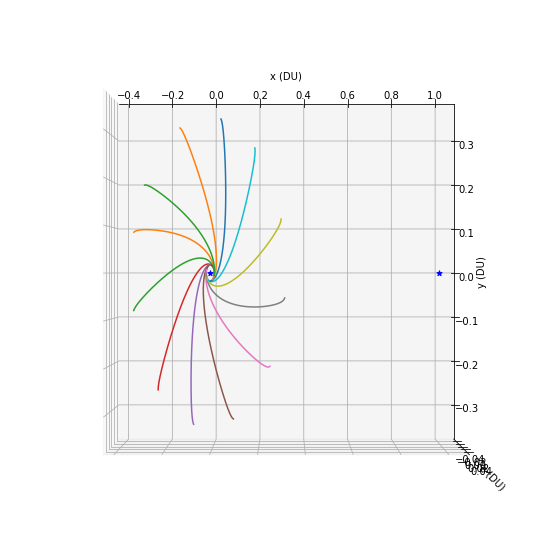

In [27]:
dvt = 2900. / a_ms

fig = plt.figure()
ax = plot_system(problem, is2d=False, withTriangularPoints=False, withCollinearPoints=False)
ax.plot(p[:,0], p[:,1], p[:,2])

propagator = Propagator(mu_ratio)
for i in range(0, len(p), 50):
    init_point = np.array(p[i, :])
    ut = init_point[3:6] / np.linalg.norm(init_point[3:6])
    dv = dvt * ut
    init_point[3:6] = init_point[3:6] + dv
    t, pb = propagator.propagate(list(init_point),[0,  15*period/a_s])
    pb = np.array(pb)
    ax.plot(pb[:,0], pb[:,1], pb[:,2])
    
ax.view_init(elev=90., azim=270)    
plt.show()

#### The junction

Merging the two previous sub-section would provide this

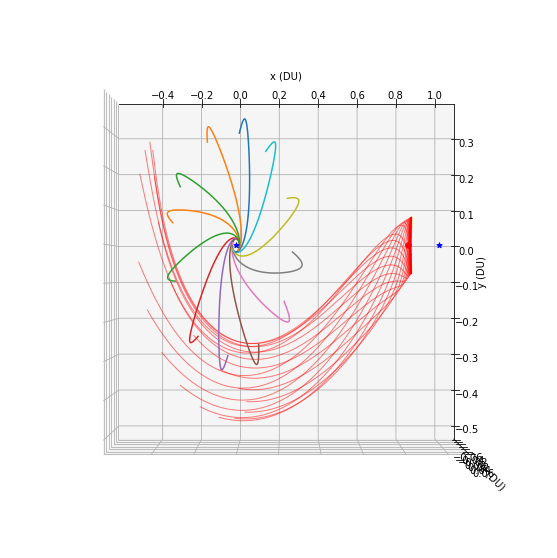

In [28]:
from r3bpy.visu import plot_system, plot_manifold, plot_trajectory
propagator = Propagator(mu_ratio)

ax=plot_system(problem, is2d=False, withTriangularPoints=False, colinearPointsList=[1])

ax.plot(p[:,0], p[:,1], p[:,2]) # LEO orbit
plot_trajectory(xyz_halo, color='orange',ax=ax) # Halo orbit

manifold = plot_manifold(mu_ratio, xyz_halo, orbit_period, stable_vector_space[0], npts=20, max_duration=-3.5, displace=0.001, color='r', ax=ax)
  
for i in range(0, len(p), 50):
    init_point = np.array(p[i, :])
    ut = init_point[3:6] / np.linalg.norm(init_point[3:6])
    dv = dvt * ut
    init_point[3:6] = init_point[3:6] + dv
    t, pb = propagator.propagate(list(init_point),[0,  23*period/a_s])
    pb = np.array(pb)
    ax.plot(pb[:,0], pb[:,1], pb[:,2])
    
ax.view_init(elev=90., azim=270)    

We should actually fix a point on the manifold, and seek the dv that reach Earth and the LEO. One easy point is that there is actually no time-phasing constraint. It is a space coordinate problem!

In [29]:
from r3bpy.main import LambertProblem

lambert = LambertProblem(mu_ratio)

We have to select the start and end points.

In [30]:
idManifoldSegment=12  # just a random choice, almost
iLeoPoint = 100  # just a random choice

tof = 0.55  # chosen manually and iteratively
print("TOF=", tof * a_s / 86400)

tm, pm = manifold[idManifoldSegment]
leo_depart_point = list(p[iLeoPoint,:])
manifold_matching_point = pm[-1]
print("r_leo=", leo_depart_point[0:3])
print("r_man=", manifold_matching_point[0:3])

TOF= 2.40041528433201
r_leo= [-0.004173057782047578, 0.01569404122133261, 0.0]
r_man= [-0.02334782 -0.47062839 -0.03596273]


We can  now called the solver. Note that the initial point is defined as a 6x1 vector for position and velocity. Indeed, we use the initial velocity as an initial guess to the numerical Lambert's solver.

In [31]:
v1, v2 = lambert.solve(list(leo_depart_point), list(manifold_matching_point[0:3]), tof)
print("v1=", v1)
print("v2=", v2) 

v1= [-10.35768627   0.27913341   0.85290938]
v2= [-0.10925955  0.50598448  0.02110411]


We can now propagate the solution, and check the final conditions

In [32]:
propagator = Propagator(mu_ratio)
init_point = np.concatenate((np.array(leo_depart_point[0:3]), np.array(v1)))
print("x0=",np.array(init_point))
t, pb = propagator.propagate(list(init_point),[0,tof])
pb = np.array(pb)
print("xf=", pb[-1,0:3])

x0= [-4.17305778e-03  1.56940412e-02  0.00000000e+00 -1.03576863e+01
  2.79133413e-01  8.52909380e-01]
xf= [-0.02334782 -0.47062839 -0.03596273]


Finally, the complete solution

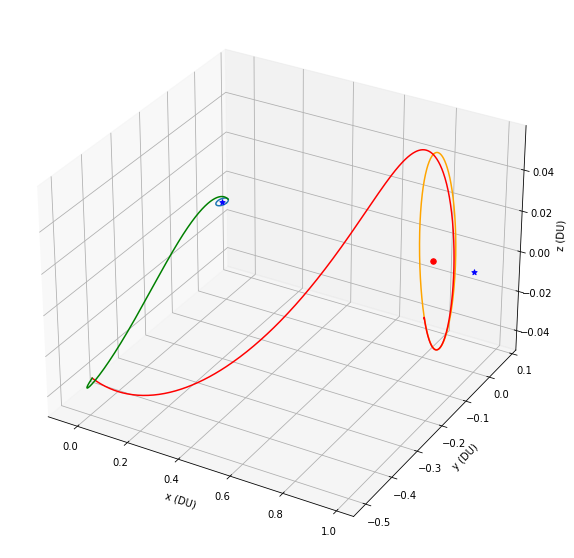

In [33]:
from r3bpy.visu import plot_system, plot_manifold, plot_trajectory

ax=plot_system(problem, is2d=False, withTriangularPoints=False, colinearPointsList=[1])

ax.plot(p[:,0], p[:,1], p[:,2]) # LEO orbit
plot_trajectory(xyz_halo, color='orange',ax=ax) # Halo orbit

tm, pm = manifold[idManifoldSegment]
pm = np.array(pm)
ax.plot(pm[:,0], pm[:,1], pm[:,2], 'r') # manifold

ax.plot(pb[:,0], pb[:,1], pb[:,2], 'g') # bridge

LEO orbit is depicted in blue, around the blue star representing the Earth. L1 point is represented by the red dot, next to the Moon, again represeted by the blue star around $x \approx 0.9$. Around Libration point L1, we plotted the Halo orbit, in orange.

The transfer from LEO to the Halo orbit is thus represented by two parts, in green and in red. The green part is a coast part in the R3BP dynamics, while the red part is actually a path along the stable manifold of the Halo orbit.


So the $\Delta V_{LEO}$ and $\Delta V_{Manifold Insertion}$ are

In [34]:
print("dV_LEO = {} m/s".format(np.linalg.norm(v1 - leo_depart_point[3:6]) * a_ms))
print("dV_MI = {} m/s".format(np.linalg.norm(v2 - manifold_matching_point[3:6]) * a_ms))

dV_LEO = 5033.081880302773 m/s
dV_MI = 1402.601270307959 m/s


To go further, we can actually optimize the matching point, to improve the transfer time, to reduce the total $\Delta V$ or, to support mission constraints.

Sensitivity to  maneuver dispersion and navigation error would be the remaining topics towards implementing the mission. With a given knowledge of the propulsion system, what would be the impact on the Halo orbit insertion and the amplitude range of the correction maneuvers.

Voilà!